# VOLVE WAVEFIELD SEPARATION 1

## Author: N. Wang

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.signal import butter, lfilter, freqz, medfilt, fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
import time
import pandas as pd

from segyshot import SegyShot
from wavefieldsep import wavefield_separation

In [2]:
# Input data (run dataprep.py to obtain the inputfile, and download the velfile directly from Volve village)
inputfile = 'ST10010_1150780_40203_2dline1.sgy'
velfile = 'ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)

In [3]:
# EBCDIC header containing textual information of the data
print(segyio.tools.wrap(f.text[0]))  

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO
SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C15 DATUM: ED50, 31N  SPHEROID: INT. 

In [4]:
# Binary header
print(f.bin)
print('JobID from binary header: ', f.bin[segyio.BinField.JobID])

{JobID: 10010, LineNumber: 0, ReelNumber: 0, Traces: 960, AuxTraces: 0, Interval: 2000, IntervalOriginal: 2000, Samples: 2000, SamplesOriginal: 5000, Format: 5, EnsembleFold: 0, SortingCode: 1, VerticalSum: 1, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 1, MeasurementSystem: 1, ImpulseSignalPolarity: 1, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}
JobID from binary header:  10010


In [5]:
# Trace header
print('First trace header', f.header[0])
print('GroupX from first trace header', f.header[0][segyio.TraceField.GroupX])

First trace header {TRACE_SEQUENCE_LINE: 4761601, TRACE_SEQUENCE_FILE: 192001, FieldRecord: 1618, TraceNumber: 1, EnergySourcePoint: 1618, CDP: 10395429, CDP_TRACE: 0, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 1, offset: 4740, ReceiverGroupElevation: -1010, SourceSurfaceElevation: 1, SourceDepth: 63, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 881, GroupWaterDepth: 1010, ElevationScalar: -10, SourceGroupScalar: -10, SourceX: 4357826, SourceY: 64765477, GroupX: 4311640, GroupY: 64776128, CoordinateUnits: 1, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 5000, TRACE_SAMPLE_INTERVAL: 2000, GainType: 1, InstrumentGainConstant: 6, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0,

In [6]:
# Velocity file
fv = segyio.open(velfile)

# Depth axes 0-4500
z = fv.samples

# Inline and crossline axes str:9963(432) str:1840(960)
il, xl = fv.ilines, fv.xlines

# Velocity model (il,xl,z) (109,241,226)
vmod = segyio.cube(velfile)

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


(49.79340614637832,
 241,
 49.54097588003794,
 109,
 (array([    0.        ,    49.99630072,   100.00230434, ...,
         11899.98054475, 11949.98412892, 11999.98042964]),
  array([-0.00000000e+00, -3.77604551e-03, -5.13264388e-03, ...,
         -5.39996637e+03, -5.39995802e+03, -5.39996180e+03])))

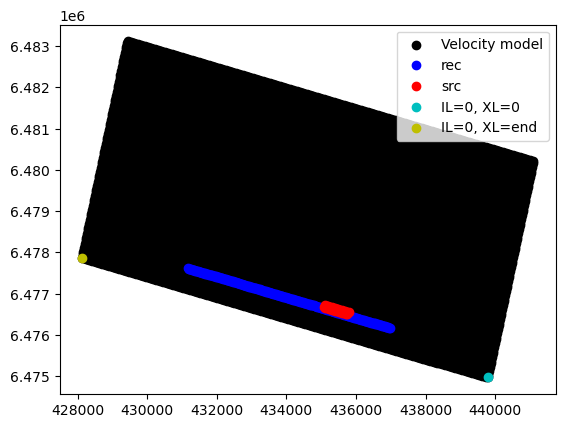

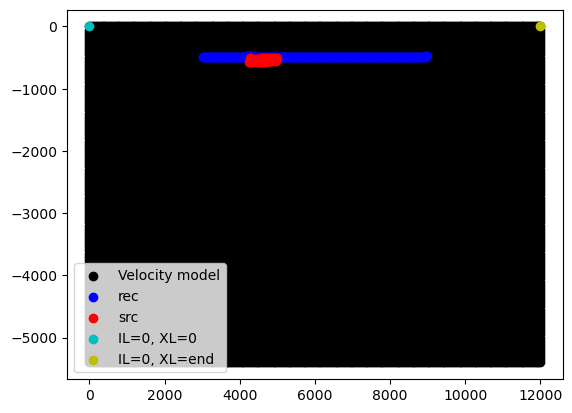

In [7]:
# Shot gather
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.rotategeometry(velfile=velfile, plotflag=1)

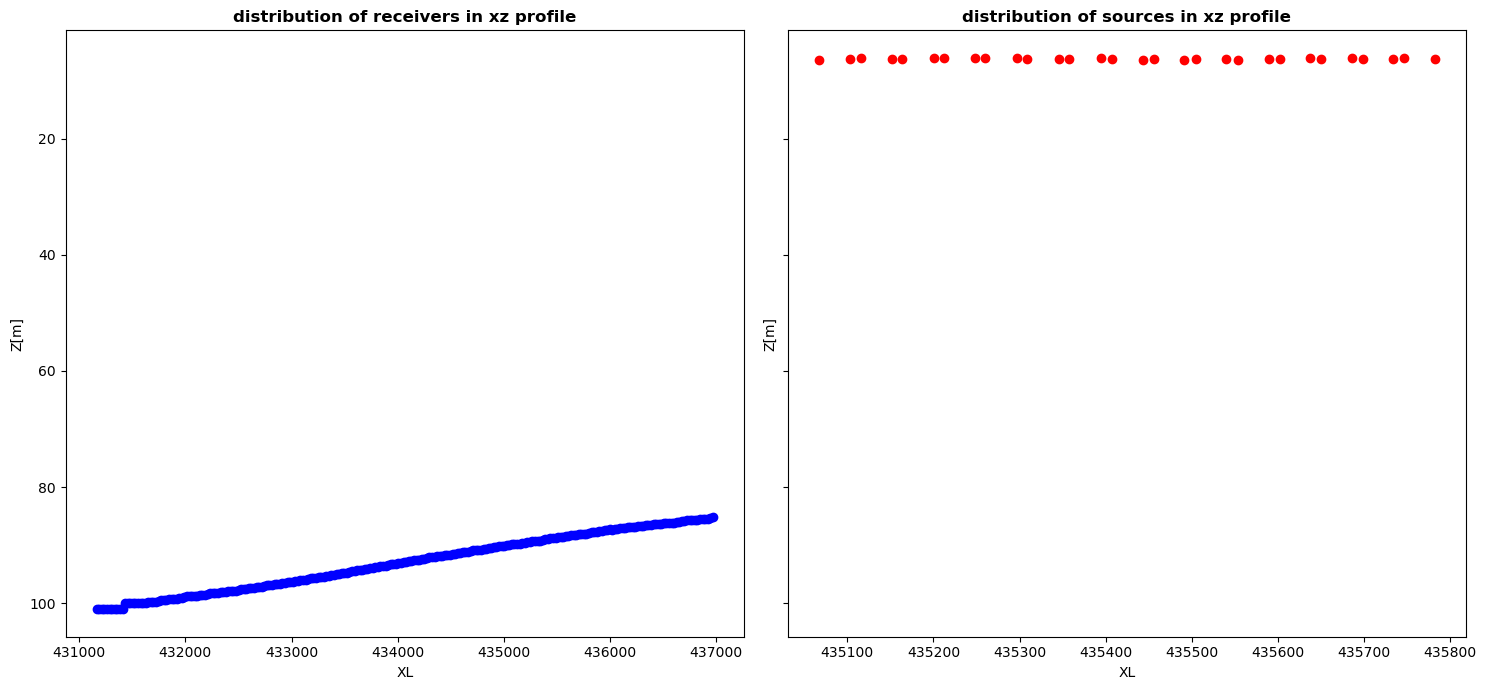

In [8]:
# geomotry of receivers and sources
recx=sg.recx
recy=sg.recy
recz=sg.recz
srcx=sg.srcx
srcy=sg.srcy
srcz=sg.srcz
num_rec=np.shape(recx)
num_src=np.shape(srcx)

fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axs[0].scatter(recx,recz,c='b')
axs[0].set_title('distribution of receivers in xz profile', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
axs[0].invert_yaxis()
axs[0].axis('tight')

axs[1].scatter(srcx,srcz,c='r')
axs[1].set_title('distribution of sources in xz profile', fontweight='bold')
axs[1].set_xlabel('XL')
axs[1].set_ylabel('Z[m]')
axs[1].axis('tight')
plt.tight_layout();


(430873.68, 437260.72000000003, 6476095.130000001, 6477685.07)

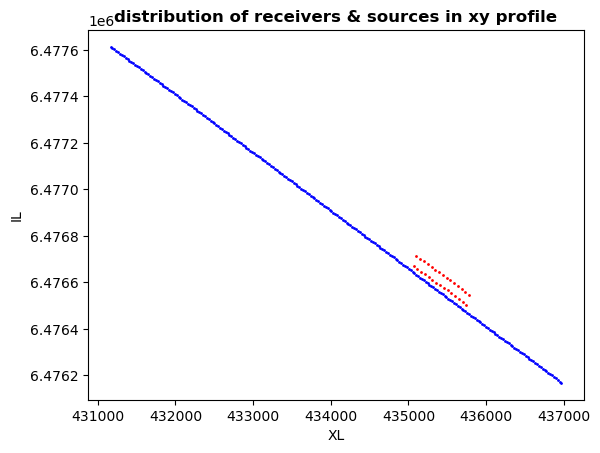

In [9]:
plt.scatter(recx,recy,c='b',s=1)
plt.scatter(srcx,srcy,c='r',s=1)
plt.title('distribution of receivers & sources in xy profile', fontweight='bold')
plt.xlabel('XL')
plt.ylabel('IL')
plt.axis('tight')


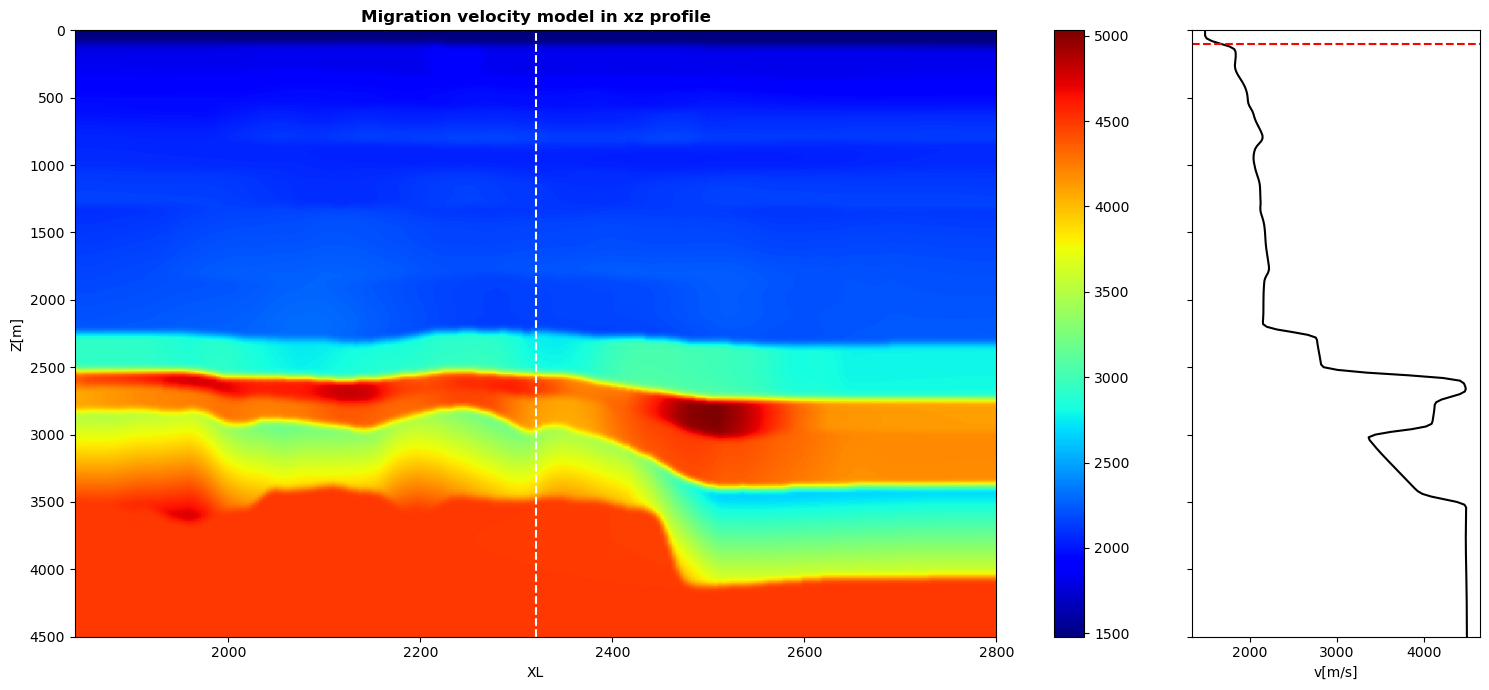

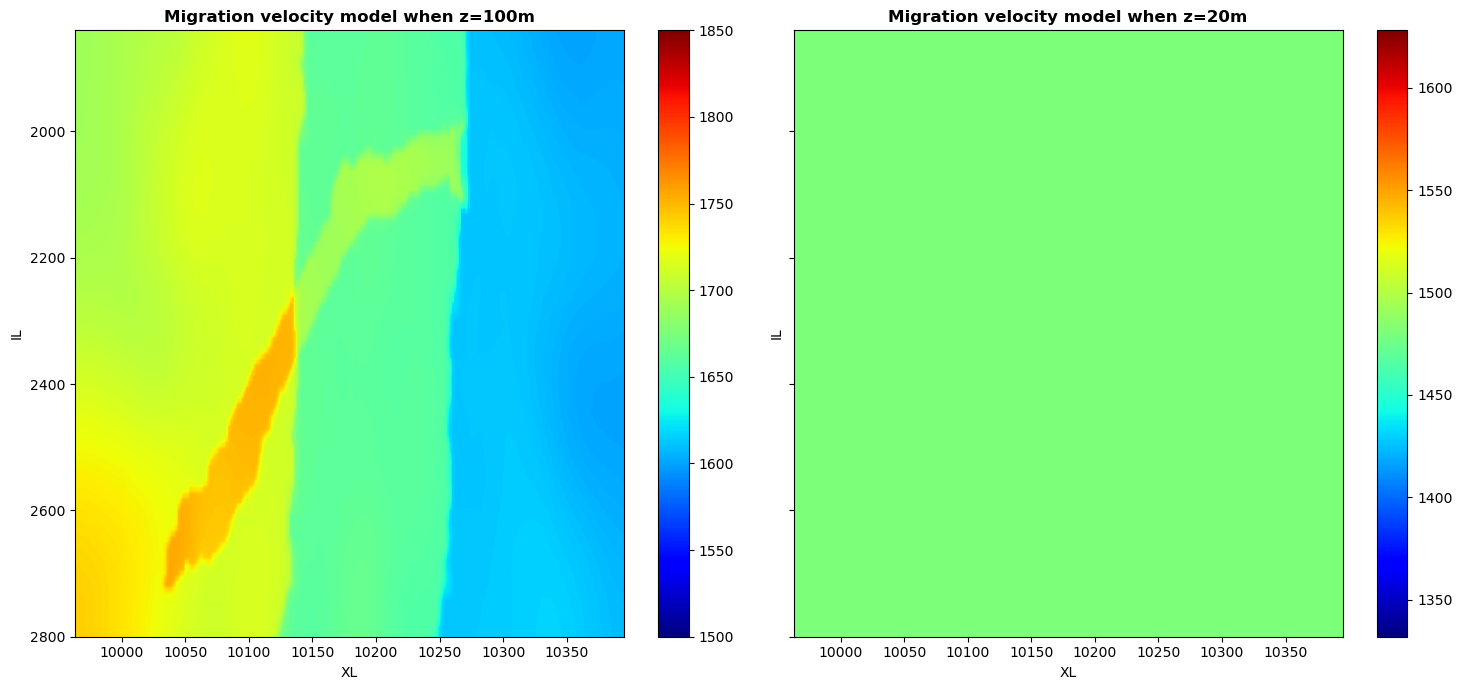

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
ax1=axs[0].imshow(vmod[50].T, extent=(xl[0], xl[-1], z[-1], z[0]), cmap='jet')
axs[0].set_title('Migration velocity model in xz profile', fontweight='bold')
axs[0].axvline(xl[120], color='w', linestyle='--')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
fig.colorbar(ax1,ax=axs[0])
axs[0].axis('tight')
axs[1].plot(vmod[50, 120], z, 'k')
axs[1].set_xlabel('v[m/s]')
axs[1].axhline(z[5], color='r', linestyle='--')
plt.tight_layout();

fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axs0=axs[0].imshow(vmod[:,:,5], cmap='jet',extent=(il[0], il[-1], xl[-1], xl[0]), vmin=1500,vmax=1850)
axs[0].set_title('Migration velocity model when z=100m', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('IL')
axs[0].axis('tight')
fig.colorbar(axs0,ax=axs[0])
axs1=axs[1].imshow(vmod[:,:,1], extent=(il[0], il[-1], xl[-1], xl[0]), cmap='jet')
axs[1].set_title('Migration velocity model when z=20m', fontweight='bold')
axs[1].set_xlabel('XL')
axs[1].set_ylabel('IL')
axs[1].axis('tight')
fig.colorbar(axs1,ax=axs[1])
plt.tight_layout();

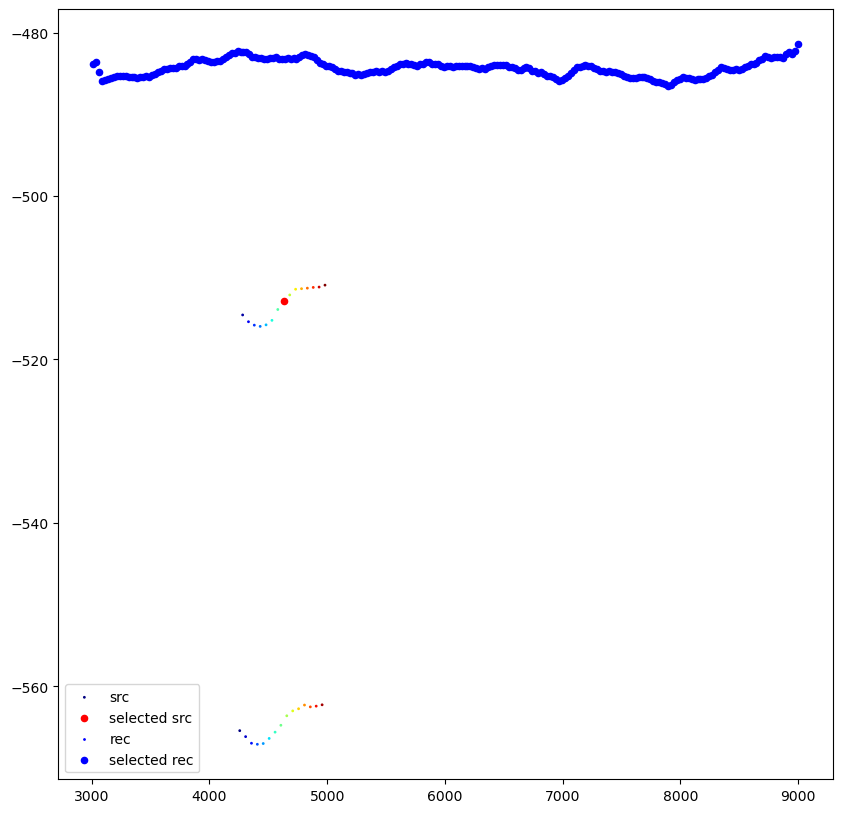

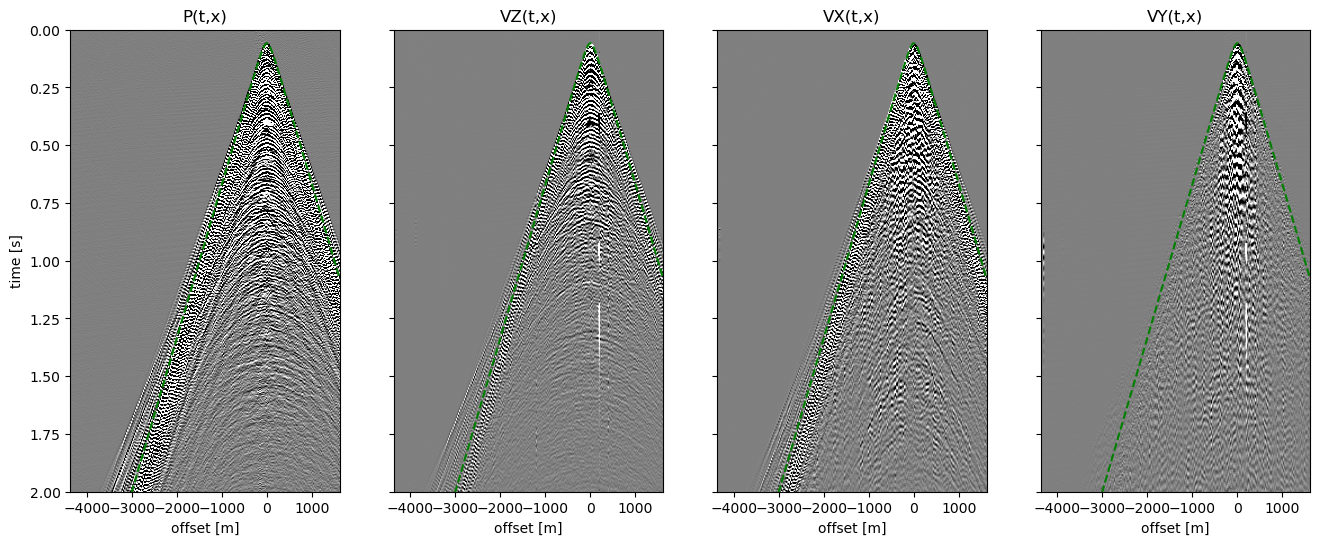

In [11]:
# Single shot
vel_dir = 1500.
ishotc = 15

sg.selectsrcs(ishotc, ishotc+1, plotflag=False)
sg.showgeometry(local=True)
shot = sg.get_shotgather(ishotc)

# Compute direct arrival
drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = np.sqrt((sg.srcx[ishotc] - sg.recx) ** 2 + (sg.srcy[ishotc] - sg.recy) ** 2)
distance = np.sqrt((sg.srcz[ishotc] - sg.recz) ** 2 + \
                   (sg.srcx[ishotc] - sg.recx) ** 2 + \
                   (sg.srcy[ishotc] - sg.recy) ** 2)
tdir = distance / vel_dir
offsetreg = np.linspace(-offset[0], offset[-1], sg.nrec)

# Display 
vmax = 2e5
cmap = 'gray'
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
axs[0].imshow(shot['P'].T, cmap=cmap, vmin=-vmax, vmax=vmax,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--g')
axs[0].set_title('P(t,x)')
axs[0].set_xlabel('offset [m]')
axs[0].set_ylabel('time [s]')
axs[0].axis('tight')
axs[1].imshow(shot['VZ'].T, cmap=cmap, vmin=-vmax/10, vmax=vmax/10,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--g')
axs[1].set_title('VZ(t,x)')
axs[1].set_xlabel('offset [m]')
axs[1].axis('tight')
axs[2].imshow(shot['VX'].T, cmap=cmap, vmin=-vmax/10, vmax=vmax/10,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[2].plot(offsetreg, tdir, '--g')
axs[2].set_title('VX(t,x)')
axs[2].set_xlabel('offset [m]')
axs[2].axis('tight')
axs[3].imshow(shot['VY'].T, cmap=cmap, vmin=-vmax/10, vmax=vmax/10,
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[3].plot(offsetreg, tdir, '--g')
axs[3].set_title('VY(t,x)')
axs[3].set_xlabel('offset [m]')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);

In [12]:
# remove the bad traces away
p1=shot['P']
p1=np.delete(p1,190,axis=0)
p1=np.delete(p1,182,axis=0)
p1=np.delete(p1,126,axis=0)
vz1=shot['VZ']
vz1=np.delete(vz1,190,axis=0)
vz1=np.delete(vz1,182,axis=0)
vz1=np.delete(vz1,126,axis=0)
np.shape(p1)

(237, 2000)

(-4365.313058647762, 1618.6583889135225, 3.998, 0.0)

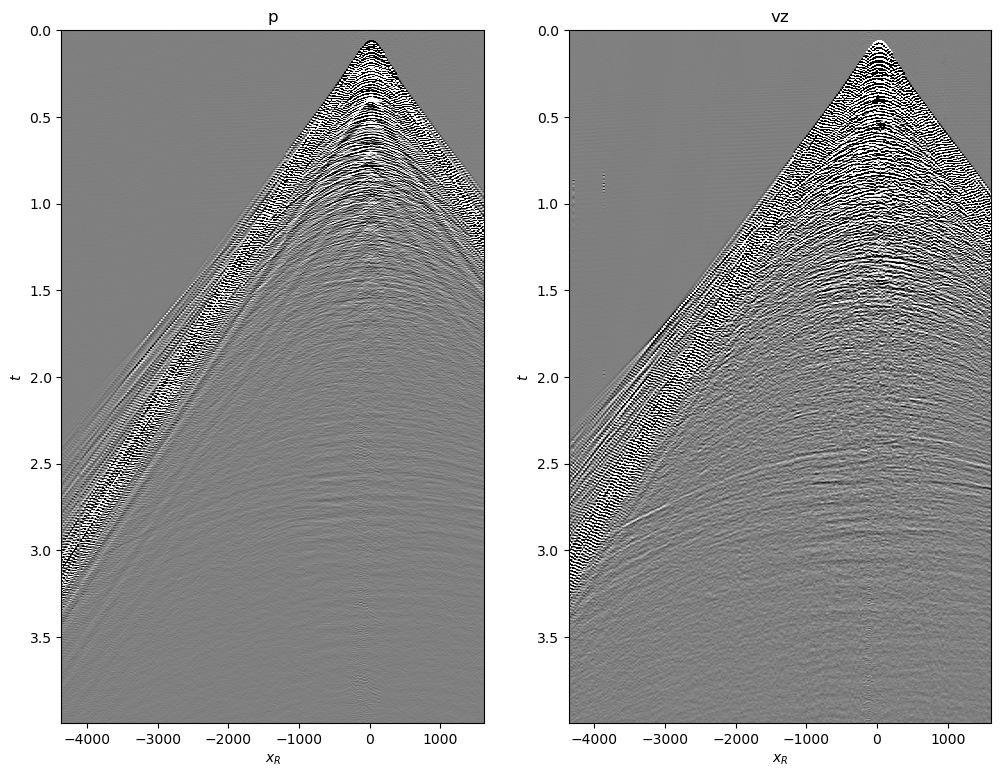

In [13]:
# -------------------p vz after removing the bad traces away-----------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(p1.T, cmap='gray', vmin=-0.001*np.abs(p1).max(), vmax=0.001*np.abs(p1).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[0].set_title('p'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(vz1.T, cmap='gray', vmin=-0.001*np.abs(vz1).max(), vmax=0.001*np.abs(vz1).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[1].set_title('vz'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')

In [15]:
# remove the aliasing effects for p 
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
nffts=(2**11, 2**11)
pfilt1 = butter_lowpass_filter(p1, 55., 1/sg.dt, 11)
Pfiltfk1 = np.fft.fft2(pfilt1, s=nffts)

# remove the aliasing effects for vz
pfilt2 = butter_lowpass_filter(vz1, 55., 1/sg.dt, 11)
Pfiltfk2 = np.fft.fft2(pfilt2, s=nffts)
tgain = np.sqrt(sg.t)
p_c=pfilt1.T * tgain[:, np.newaxis]
vz_c=pfilt2.T * tgain[:, np.newaxis]

(-4365.313058647762, 1618.6583889135225, 3.998, 0.0)

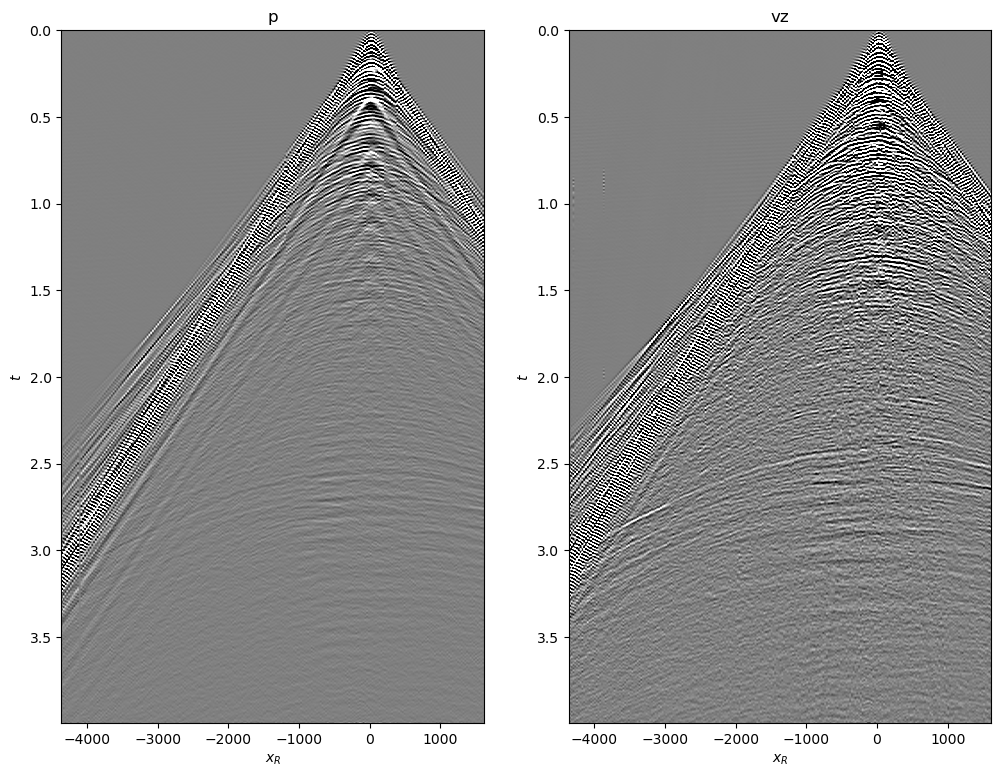

In [16]:
# -------------------p vz after processing-----------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(p_c, cmap='gray', vmin=-0.001*np.abs(p1).max(), vmax=0.001*np.abs(p1).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[0].set_title('p'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(vz_c, cmap='gray', vmin=-0.001*np.abs(vz1).max(), vmax=0.001*np.abs(vz1).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[1].set_title('vz'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')

In [19]:
# wavefield sepration
p=np.zeros((1,237,2000), dtype=float)
vz=np.zeros((1,237,2000), dtype=float)
p[0]=-p_c.T
vz[0]=vz_c.T/28000
np.shape(p)

p_f=p[:,:,::1]
vz_f=vz[:,:,::1]
rho_sep = 1000      # density at receiver
vel_sep = 1660      # velocity at receiver
dt=sg.t[1]-sg.t[0]
dr=offsetreg[1]-offsetreg[0]
nffts=(2**11, 2**11)

vzup_q, vzdown_q =wavefield_separation(p_f, vz_f, dt, dr, rho_sep, vel_sep, nffts=nffts,
                                       critical=110, ntaper=51, verb=True, plotflag=False)

Working with source 0


(-4365.313058647762, 1618.6583889135225, 3.998, 0.0)

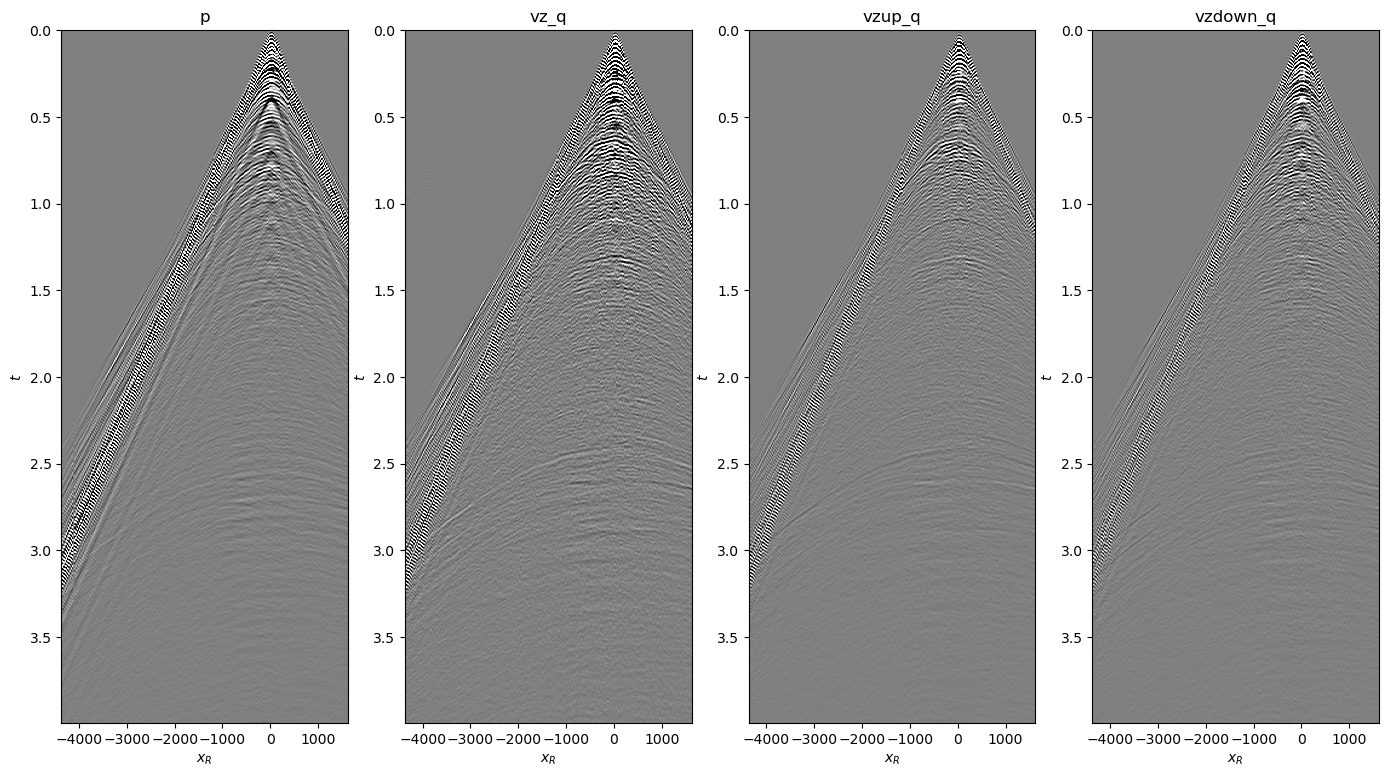

In [20]:
sz=0.018
fig, axs = plt.subplots(1, 4, figsize=(17, 9))
axs[0].imshow(p_f[0].T, cmap='gray', vmin=-sz*np.abs(p).max(), vmax=sz*np.abs(p).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[0].set_title('p'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(vz_f[0].T, cmap='gray', vmin=-sz*np.abs(vz).max(), vmax=sz*np.abs(vz).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[1].set_title('vz_q'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[2].imshow(vzup_q[0].T, cmap='gray', vmin=-sz*np.abs(vz).max(), vmax=sz*np.abs(vz).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[2].set_title('vzup_q'), axs[2].set_xlabel(r'$x_R$'), axs[2].set_ylabel(r'$t$')
axs[2].axis('tight')
axs[3].imshow(vzdown_q[0].T, cmap='gray', vmin=-sz*np.abs(vz).max(), vmax=sz*np.abs(vz).max(),
              extent = (offsetreg[0], offsetreg[-1], sg.t[-1], sg.t[0]))
axs[3].set_title('vzdown_q'), axs[3].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[3].axis('tight')